# Colab Start Section

Step 1 is to upload a copy of your private key. I am assuming your private key is named id_ed25519. If that isn't the case, you'll have to make manual changes.

In [1]:
# Change these of course to what is your email and your GitHub username
EMAIL = "pauleanderson@gmail.com"
USERNAME = "pauleanderson"
ORG = "anderson-fall-2024"

In [2]:
from google.colab import files
uploaded = files.upload()

Saving id_ed25519 to id_ed25519


In [3]:
%%bash -s "$EMAIL" "$USERNAME"

rm -rf /root/.ssh/*
mkdir /root/.ssh

mv id_ed25519 /root/.ssh/

chmod 600 /root/.ssh/id_ed25519

git config --global user.email "$1"
git config --global user.name "$2"

In [8]:
%%bash -s "$USERNAME" "$ORG"

eval "$(ssh-agent -s)"

ssh-add ~/.ssh/id_ed25519

ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

git clone git@github.com:$2/csc-487-$1.git

Agent pid 726


Identity added: /root/.ssh/id_ed25519 (pauleanderson@gmail.com)
# github.com:22 SSH-2.0-babeld-cd94d92b7
Cloning into 'csc-487-instructor'...


In [2]:
%load_ext autoreload
%autoreload 2


from pathlib import Path
home = str(Path.home()) # all other paths are relative to this path. change to something else if this is not the case on your system

import sys
sys.path.insert(0,f"csc-487-{USERNAME}")
sys.path.insert(0,"..")

import py487

In [3]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Exercises
========================

## Notes:
In this assignment and when calculating the log, I add a small value 1e-10 to make sure that we are always > 0.

### Generate a dataset

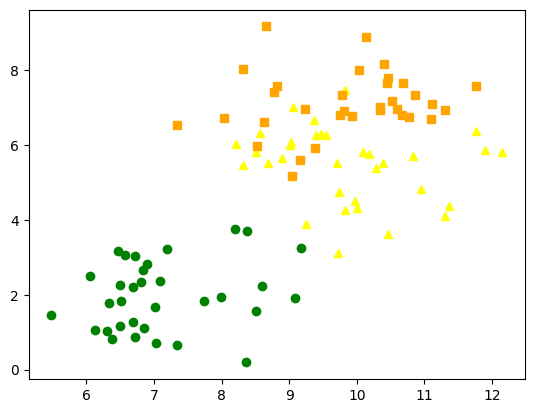

In [6]:
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
np.random.seed(4)
X, t = datasets.make_blobs(n_samples=100, centers=3, n_features=2, center_box=(0, 10))
plt.plot(X[:, 0][t == 0], X[:, 1][t == 0], marker='^',linestyle="None" ,color='yellow')
plt.plot(X[:, 0][t == 1], X[:, 1][t == 1], marker='s',linestyle="None",color='orange')
plt.plot(X[:, 0][t == 2], X[:, 1][t == 2], marker='o',linestyle="None",color='green')
plt.show()

For give the colors and how they show on the screen, I'm choosing them to represent a ficticious orange, lemons, and limes.

In [7]:
import pandas as pd
t_fruit = pd.Series(t).map({0:"Lemon",1:"Orange",2:"Lime"})
t_fruit

0     Orange
1      Lemon
2     Orange
3     Orange
4      Lemon
       ...  
95      Lime
96     Lemon
97      Lime
98      Lime
99     Lemon
Length: 100, dtype: object

## Loss functions

We need a simple classifier to examine our loss functions. We'll stick with k-nearest neighbor classifier for this example. We will use the sklearn implementation.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X, t_fruit)

KNeighborsClassifier(n_neighbors=3)

In [9]:
y_fruit_pred = clf.predict(X)
from sklearn.metrics import classification_report
print(classification_report(t_fruit, y_fruit_pred))

              precision    recall  f1-score   support

       Lemon       0.87      0.97      0.92        34
        Lime       1.00      0.97      0.98        33
      Orange       0.97      0.88      0.92        33

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [10]:
y_fruit_probs_pred = pd.DataFrame(clf.predict_proba(X),columns=clf.classes_)
y_fruit_probs_pred

,Lemon,Lime,Orange
0,0.333333,0.000000,0.666667
1,1.000000,0.000000,0.000000
2,0.333333,0.000000,0.666667
3,0.000000,0.000000,1.000000
4,0.666667,0.000000,0.333333
...,...,...,...
95,0.000000,1.000000,0.000000
96,0.666667,0.000000,0.333333
97,0.000000,1.000000,0.000000
98,0.000000,1.000000,0.000000


Because we are going to start incorporating pytorch, I am going to show you their built-in functions. Below is the KL-divergence. Before we can call that function, we need to define the target. Here ya go:

In [11]:
y_fruit_probs = pd.get_dummies(t_fruit).astype(float)
y_fruit_probs

,Lemon,Lime,Orange
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0
...,...,...,...
95,0.0,1.0,0.0
96,1.0,0.0,0.0
97,0.0,1.0,0.0
98,0.0,1.0,0.0


In [12]:
import torch
?torch.nn.functional.kl_div

Signature:
torch.nn.functional.kl_div(
    input: torch.Tensor,
    target: torch.Tensor,
    size_average: Optional[bool] = None,
    reduce: Optional[bool] = None,
    reduction: str = 'mean',
    log_target: bool = False,
) -> torch.Tensor
Docstring:
Compute the KL Divergence loss.

Refer - The `Kullback-Leibler divergence Loss
<https://en.wikipedia.org/wiki/Kullback-Leibler_divergence>`__

See :class:`~torch.nn.KLDivLoss` for details.

Args:
    input: Tensor of arbitrary shape in log-probabilities.
    target: Tensor of the same shape as input. See :attr:`log_target` for
        the target's interpretation.
    size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
        the losses are averaged over each loss element in the batch. Note that for
        some losses, there multiple elements per sample. If the field :attr:`size_average`
        is set to ``False``, the losses are instead summed for each minibatch. Ignored
        when reduce is ``False``. De

In [13]:
import torch
float(torch.nn.functional.kl_div(torch.tensor(np.log(y_fruit_probs_pred.values+1e-10)), torch.tensor(y_fruit_probs.values),reduction='batchmean').numpy())


0.15106440990030112

Now let's implement our own KL-divergence

<img src="https://miro.medium.com/max/566/1*pqnS3f2aWcKSFqfXxx75JQ.png">

$$
KL(P_i||Q_i) = \sum_{x \in X} p_i(x) log \left( \frac{p_i(x)}{q_i(x)} \right)
$$

$$
KL(P_i||Q_i) = \sum_{x \in \{Lemon,Lime,Orange\}} p_i(x) log \left( \frac{p_i(x)}{q_i(x)} \right)
$$

$$
kl\_div(...) = \frac{\sum_{i=0}^{99} KL(P_i||Q_i)}{100}
$$

In this notation, $P$ is target.

In [14]:
y_fruit_probs_pred

,Lemon,Lime,Orange
0,0.333333,0.000000,0.666667
1,1.000000,0.000000,0.000000
2,0.333333,0.000000,0.666667
3,0.000000,0.000000,1.000000
4,0.666667,0.000000,0.333333
...,...,...,...
95,0.000000,1.000000,0.000000
96,0.666667,0.000000,0.333333
97,0.000000,1.000000,0.000000
98,0.000000,1.000000,0.000000


In [15]:
y_fruit_probs

,Lemon,Lime,Orange
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0
...,...,...,...
95,0.0,1.0,0.0
96,1.0,0.0,0.0
97,0.0,1.0,0.0
98,0.0,1.0,0.0


In [16]:
py487.functional.kl_div(np.log(y_fruit_probs_pred.values+1e-10),y_fruit_probs.values)

np.float64(0.1510644100003011)

## Cross-entropy

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/39d0c6b14cd7381cd3145718f693c114b84e7960">


Again $P$ is target.

In [17]:
?torch.nn.functional.cross_entropy

Signature:
torch.nn.functional.cross_entropy(
    input: torch.Tensor,
    target: torch.Tensor,
    weight: Optional[torch.Tensor] = None,
    size_average: Optional[bool] = None,
    ignore_index: int = -100,
    reduce: Optional[bool] = None,
    reduction: str = 'mean',
    label_smoothing: float = 0.0,
) -> torch.Tensor
Docstring:
Compute the cross entropy loss between input logits and target.

See :class:`~torch.nn.CrossEntropyLoss` for details.

Args:
    input (Tensor) : Predicted unnormalized logits;
        see Shape section below for supported shapes.
    target (Tensor) : Ground truth class indices or class probabilities;
        see Shape section below for supported shapes.
    weight (Tensor, optional): a manual rescaling weight given to each
        class. If given, has to be a Tensor of size `C`
    size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
        the losses are averaged over each loss element in the batch. Note that for
        som

In [18]:
float(torch.nn.functional.cross_entropy(
    torch.tensor(np.log(y_fruit_probs_pred.values+1e-10)),
    torch.tensor(y_fruit_probs.values)).numpy())

0.15106441020030112

In [19]:
py487.functional.cross_entropy(np.log(y_fruit_probs_pred.values+1e-10),y_fruit_probs.values)

np.float64(0.1510644099003011)

In [21]:
# Good job!
# Woohoo!

# Test your code

In [34]:
%%bash -s "$USERNAME"

cd csc-487-$1/tests
pytest test_Assignment3.py

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.5.0
rootdir: /content/csc-487-instructor/tests
plugins: anyio-3.7.1, typeguard-4.3.0
collected 2 items

test_Assignment3.py ..                                                                       [100%]

======================================== 2 passed in 4.36s =========================================


# Colab End Section - Submit your code

In [35]:
%%bash -s "$USERNAME"

eval "$(ssh-agent -s)"

ssh-add ~/.ssh/id_ed25519

ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

cd csc-487-$1
git add .
git commit -m update
git push
#./command_line_sync.sh # if you want to sync

Agent pid 5184
[main 5849bef] update
 2 files changed, 42 insertions(+)
 create mode 100644 tests/answers_Assignment3.joblib
 create mode 100644 tests/test_Assignment3.py


Identity added: /root/.ssh/id_ed25519 (pauleanderson@gmail.com)
# github.com:22 SSH-2.0-babeld-cd94d92b7
remote: This repository moved. Please use the new location:        
remote:   git@github.com:Anderson-Lab/csc-487-instructor.git        
To github.com:anderson-lab/csc-487-instructor.git
   b93bd8a..5849bef  main -> main
